In [22]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import re
from tqdm.notebook import tqdm
import ipywidgets as widgets
widgets.IntProgress(value=50, min=0, max=100)
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

Load Dataset

In [3]:
class BinauralCueDataset(Dataset):
    def __init__(self, npz_dir, audio_ids=range(1, 701)):
        self.dir = npz_dir
        pattern = re.compile(r'main_audio_(\d+)_azi(\d+)\.npz')
        self.files = []
        for f in os.listdir(npz_dir):
            if f.endswith('.npz'):
                match = pattern.match(f)
                if match and int(match.group(1)) in audio_ids:
                    self.files.append(f)
        self.files.sort()

        print(f"📁 已加载 {len(self.files)} 个 .npz 文件，共 {len(self)} 个样本。")

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = os.path.join(self.dir, self.files[idx])
        data = np.load(path)
        itd = data["itd"].astype(np.float32)
        ild = data["ild"].astype(np.float32)
        ic = data["ic"].astype(np.float32)

        cue = np.stack([itd, ild, ic], axis=0)  # [3, filters, frames]

        # 提取 azimuth label
        azimuth = int(re.search(r'azi(\d+)', self.files[idx]).group(1))
        label = azimuth // 5  # 共72类（0-71）

        return cue, label

Model1

In [7]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample
        if downsample or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class AzimuthResNetCNN(nn.Module):
    def __init__(self, num_classes=72):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.layer1 = ResBlock(32, 64, downsample=True)
        self.layer2 = ResBlock(64, 128, downsample=True)
        self.layer3 = ResBlock(128, 128)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)        # shape: [B, 128, 1, 1]
        x = torch.flatten(x, 1) # shape: [B, 128]
        x = self.dropout(x)
        return self.fc(x)

Model2

In [28]:
# conv_config = [
#     {'in_ch': 32, 'out_ch': 64, 'kernel_size': 5, 'pool': None, 'residual': False},
#     {'in_ch': 64, 'out_ch': 64, 'kernel_size': 5, 'pool': None, 'residual': False},
# ]



# 一维卷积分支：包含 Conv1d 层、BatchNorm1d 和 ReLU 激活
class ConvBranch(nn.Module):
    def __init__(self, input_channels=32, conv_channels=64, kernel_size=5, stride=1, num_layers=2, use_batchnorm=True):
        super(ConvBranch, self).__init__()
        layers = []
        in_ch = input_channels
        for i in range(num_layers):
            out_ch = conv_channels
            layers.append(nn.Conv1d(in_ch, out_ch, kernel_size, stride, padding=kernel_size//2))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(out_ch))
            layers.append(nn.ReLU(inplace=True))
            in_ch = out_ch
        self.conv = nn.Sequential(*layers)
    def forward(self, x):
        # x: [B, input_channels, L]  （L为时间长度，如44100）
        return self.conv(x)         # 输出: [B, conv_channels, L]

# 自注意力池化：将可变长度的时间序列特征加权汇聚为一个固定向量
class SelfAttentionPooling(nn.Module):
    def __init__(self, embed_dim):
        super(SelfAttentionPooling, self).__init__()
        # 可学习的线性层，用于计算每个时间步的注意力分数
        self.attn_score = nn.Linear(embed_dim, 1)
    def forward(self, x):
        # x: [B, L, embed_dim]  （输入特征需先调换维度到 [时间步, 特征]）
        scores = self.attn_score(x)                 # 计算注意力分数: [B, L, 1]
        weights = torch.softmax(scores, dim=1)      # 对时间维度做softmax归一化
        context = (x * weights).sum(dim=1)          # 加权求和得到上下文向量: [B, embed_dim]
        return context

# 单个线索分支模块：Conv1D 提取特征 + 注意力池化得到线索表示向量
class CueBranch(nn.Module):
    def __init__(self, input_channels=32, conv_channels=64, kernel_size=5, stride=1, num_layers=2, embed_dim=None, use_batchnorm=True):
        super(CueBranch, self).__init__()
        self.conv_net = ConvBranch(input_channels, conv_channels, kernel_size, stride, num_layers, use_batchnorm)
        # 设置嵌入维度：若未指定则与卷积输出通道数相同
        self.embed_dim = conv_channels if embed_dim is None else embed_dim
        # 若需要将卷积输出映射到不同的embed_dim，可添加线性层
        if embed_dim is not None and embed_dim != conv_channels:
            self.proj = nn.Linear(conv_channels, embed_dim)
        else:
            self.proj = None
        self.attn_pool = SelfAttentionPooling(self.embed_dim)
    def forward(self, x):
        # x: [B, input_channels, L]
        feat = self.conv_net(x)               # 卷积提取特征: [B, conv_channels, L]
        feat = feat.transpose(1, 2)           # 调整为 [B, L, conv_channels] 以方便注意力计算
        if self.proj is not None:
            feat = self.proj(feat)           # 可选：映射到指定的嵌入维度 [B, L, embed_dim]
        cue_vector = self.attn_pool(feat)     # 注意力池化得到线索上下文向量: [B, embed_dim]
        return cue_vector

# 主模型：包含三个线索分支、跨线索自注意力层和最终分类器
class SoundLocalizationModel(nn.Module):
    def __init__(self, num_classes=72, input_channels_per_cue=32, conv_channels=64, kernel_size=5, stride=1,
                 num_layers=2, embed_dim=64, num_heads=4, use_batchnorm=True):
        super(SoundLocalizationModel, self).__init__()
        # 三个独立的线索分支
        self.cue_branches = nn.ModuleList([
            CueBranch(input_channels_per_cue, conv_channels, kernel_size, stride, num_layers, embed_dim, use_batchnorm)
            for _ in range(3)
        ])
        # 跨线索多头自注意力层，将 embed_dim 维的3个线索向量作为序列
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)            # 层归一化，规范注意力输出
        # 全连接分类层，将3*embed_dim映射为num_classes（72个方位角类别）
        self.fc = nn.Linear(embed_dim * 3, num_classes)
    def forward(self, x):
        # x: [B, 3, 32, L]  其中3表示三个线索通道 (ITD, ILD, IC)
        B, cue_count, C, L = x.shape
        assert cue_count == 3, "模型期望输入包含3个线索通道"
        # 分别通过每个线索分支提取表示向量
        cue_vectors = []  # 将收集每个分支输出 [B, embed_dim]
        for i, branch in enumerate(self.cue_branches):
            cue_input = x[:, i]                   # 取出第 i 个线索: [B, 32, L]
            vec = branch(cue_input)               # 得到该线索的表示向量: [B, embed_dim]
            cue_vectors.append(vec)
        # 将三个线索向量堆叠成序列，形状 [B, 3, embed_dim]
        seq = torch.stack(cue_vectors, dim=1)
        # 自注意力层：让每个线索向量与其他线索交互得到新的表示
        attn_out, _ = self.cross_attn(seq, seq, seq)   # [B, 3, embed_dim]
        attn_out = self.norm(attn_out)                 # 层归一化输出
        # 将3个线索向量展平为单一向量 [B, 3*embed_dim]
        combined = attn_out.reshape(B, -1)
        # 全连接分类，输出72维类别分数
        logits = self.fc(combined)                     # [B, 72]
        # 模型输出为未归一化的得分，可在需要时使用 Softmax 做归一化:
        # probs = torch.softmax(logits, dim=1)
        return logits

# 使用模型示例：创建模型并测试一次前向传播
model = SoundLocalizationModel(num_classes=72, input_channels_per_cue=32, conv_channels=64, kernel_size=5,
                               stride=1, num_layers=2, embed_dim=64, num_heads=4, use_batchnorm=True)
dummy_input = torch.randn(8, 3, 32, 44100)   # 假设批大小B=8
output = model(dummy_input)
print("输出维度:", output.shape)  # 应为 [8, 72]

输出维度: torch.Size([8, 72])


Model3

In [6]:
conv_config = [
    {'in_ch': 32, 'out_ch': 64, 'kernel_size': 5, 'pool': None, 'residual': True},
    {'in_ch': 64, 'out_ch': 64, 'kernel_size': 5, 'pool': 2, 'residual': True},
    {'in_ch': 64, 'out_ch': 128, 'kernel_size': 3, 'pool': None, 'residual': True},
    {'in_ch': 128, 'out_ch': 128, 'kernel_size': 3, 'pool': 2, 'residual': True},
    {'in_ch': 128, 'out_ch': 256, 'kernel_size': 3, 'pool': None, 'residual': True},
    {'in_ch': 256, 'out_ch': 256, 'kernel_size': 3, 'pool': None, 'residual': True},
]

In [24]:
import torch
import torch.nn as nn

# Residual Block
class ResidualConvLayer(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride=1, pool=None, use_batchnorm=True):
        super(ResidualConvLayer, self).__init__()
        padding = kernel_size // 2

        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size, stride, padding=padding)
        self.bn1 = nn.BatchNorm1d(out_ch) if use_batchnorm else nn.Identity()
        self.relu = nn.ReLU(inplace=True)

        self.downsample = None
        if in_ch != out_ch:
            self.downsample = nn.Conv1d(in_ch, out_ch, kernel_size=1)
        self.pool = nn.MaxPool1d(pool, stride=pool) if pool else nn.Identity()

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)

        if self.downsample:
            identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        out = self.pool(out)
        return out

# Basic Block
class BasicConvLayer(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, stride=1, pool=None, use_batchnorm=True):
        super(BasicConvLayer, self).__init__()
        padding = kernel_size // 2
        layers = [
            nn.Conv1d(in_ch, out_ch, kernel_size, stride, padding=padding)
        ]
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(out_ch))
        layers.append(nn.ReLU(inplace=True))
        if pool:
            layers.append(nn.MaxPool1d(pool, stride=pool))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


# Conv1D for learning binaural cues
class ConvBranch(nn.Module):
    def __init__(self, conv_config, use_batchnorm=True):
        super(ConvBranch, self).__init__()
        layers = []

        for cfg in conv_config:
            layer_cls = ResidualConvLayer if cfg.get("residual", False) else BasicConvLayer
            layer = layer_cls(
                in_ch = cfg["in_ch"],
                out_ch = cfg["out_ch"],
                kernel_size = cfg["kernel_size"],
                stride = cfg.get("stride", 1),
                pool = cfg.get("pool", None),
                use_batchnorm = use_batchnorm
            )
            layers.append(layer)

        self.conv = nn.Sequential(*layers)
    def forward(self, x):
        # x: [B, input_channels, L]  （L为时间长度，如44100）
        return self.conv(x)         # output: [B, conv_channels, L]

# 自注意力池化：将可变长度的时间序列特征加权汇聚为一个固定向量
class SelfAttentionPooling(nn.Module):
    def __init__(self, embed_dim):
        super(SelfAttentionPooling, self).__init__()
        # 可学习的线性层，用于计算每个时间步的注意力分数
        self.attn_score = nn.Linear(embed_dim, 1)
    def forward(self, x):
        # x: [B, L, embed_dim]  （输入特征需先调换维度到 [时间步, 特征]）
        scores = self.attn_score(x)                 # 计算注意力分数: [B, L, 1]
        weights = torch.softmax(scores, dim=1)      # 对时间维度做softmax归一化
        context = (x * weights).sum(dim=1)          # 加权求和得到上下文向量: [B, embed_dim]
        return context

# 单个线索分支模块：Conv1D 提取特征 + 注意力池化得到线索表示向量
class CueBranch(nn.Module):
    def __init__(self, conv_config, embed_dim=None, use_batchnorm=True):
        super(CueBranch, self).__init__()
        # 自动从最后一层卷积中获取输出通道
        final_out_ch = conv_config[-1]['out_ch']
        self.embed_dim = final_out_ch if embed_dim is None else embed_dim

        self.conv_net = ConvBranch(conv_config, use_batchnorm)

        # 如果卷积输出维度不等于目标嵌入维度，则加一个线性映射层
        self.proj = nn.Linear(final_out_ch, self.embed_dim) if self.embed_dim != final_out_ch else None
        self.attn_pool = SelfAttentionPooling(self.embed_dim)

    def forward(self, x):
        feat = self.conv_net(x)           # 卷积提取特征: [B, C, L]
        feat = feat.transpose(1, 2)       # 转换为 [B, L, C]
        if self.proj is not None:
            feat = self.proj(feat)        # 映射到嵌入维度
        cue_vector = self.attn_pool(feat) # 注意力池化
        return cue_vector


# 主模型：包含三个线索分支、跨线索自注意力层和最终分类器
class SoundLocalizationModel(nn.Module):
    def __init__(self, conv_config, num_classes=72, embed_dim=256, num_heads=4, use_batchnorm=True):
        super(SoundLocalizationModel, self).__init__()
        # 三个独立的线索分支
        self.cue_branches = nn.ModuleList([
            CueBranch(conv_config, embed_dim=embed_dim, use_batchnorm=use_batchnorm)
            for _ in range(3)
        ])

        # 跨线索多头自注意力层，将 embed_dim 维的3个线索向量作为序列
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)            # 层归一化，规范注意力输出
        # 全连接分类层，将3*embed_dim映射为num_classes（72个方位角类别）
        # self.dropout = nn.Dropout(p=0.2)
        self.fc = nn.Linear(embed_dim * 3, num_classes)
    def forward(self, x):
        # x: [B, 3, 32, L]  其中3表示三个线索通道 (ITD, ILD, IC)
        B, cue_count, C, L = x.shape
        assert cue_count == 3, "模型期望输入包含3个线索通道"
        # 分别通过每个线索分支提取表示向量
        cue_vectors = []  # 将收集每个分支输出 [B, embed_dim]
        for i, branch in enumerate(self.cue_branches):
            cue_input = x[:, i]                   # 取出第 i 个线索: [B, 32, L]
            vec = branch(cue_input)               # 得到该线索的表示向量: [B, embed_dim]
            cue_vectors.append(vec)
        # 将三个线索向量堆叠成序列，形状 [B, 3, embed_dim]
        seq = torch.stack(cue_vectors, dim=1)
        # 自注意力层：让每个线索向量与其他线索交互得到新的表示
        attn_out, _ = self.cross_attn(seq, seq, seq)   # [B, 3, embed_dim]
        attn_out = self.norm(attn_out)                 # 层归一化输出
        # 将3个线索向量展平为单一向量 [B, 3*embed_dim]
        combined = attn_out.reshape(B, -1)
        # combined = self.dropout(combined)
        # 全连接分类，输出72维类别分数
        logits = self.fc(combined)                     # [B, 72]
        # 模型输出为未归一化的得分，可在需要时使用 Softmax 做归一化:
        # probs = torch.softmax(logits, dim=1)
        return logits

In [9]:
full_dataset = BinauralCueDataset(r"C:\Users\TIANY1\OneDrive - Trinity College Dublin\Documents\SoundSourceLocalization\features")
train_dataset, val_dataset = random_split(full_dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

📁 已加载 50400 个 .npz 文件，共 50400 个样本。


In [25]:
# model = AzimuthResNetCNN(num_classes=72)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The device type is: ", device)
model = SoundLocalizationModel(conv_config).to(device)

The device type is:  cuda


In [26]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

Training

Epoch 1/20:   0%|          | 0/1260 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/315 [00:00<?, ?it/s]

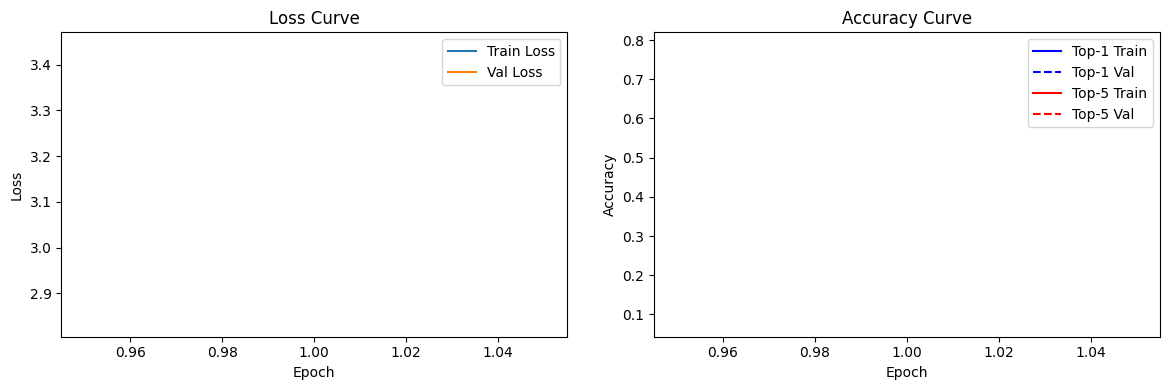

Epoch 1/20: Train Loss=3.4405, Top-1=7.84%, Top-5=66.71% | Evaluation Loss=2.8357, Top-1=14.50%, Top-5=78.43%


Epoch 2/20:   0%|          | 0/1260 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
num_epochs = 20
best_acc1 = 0.0
best_epoch = 0
best_model_wts = None

train_loss_history, val_loss_history = [], []
train_acc1_history, val_acc1_history = [], []
train_acc5_history, val_acc5_history = [], []

os.makedirs(r"C:\Users\TIANY1\OneDrive - Trinity College Dublin\Documents\SoundSourceLocalization\checkpoints", exist_ok=True)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].set_title("Loss Curve")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
train_loss_line, = axs[0].plot([], [], label='Train Loss')
val_loss_line, = axs[0].plot([], [], label='Val Loss')
axs[0].legend()

axs[1].set_title("Accuracy Curve")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
train_acc1_line, = axs[1].plot([], [], 'b-', label='Top-1 Train')
val_acc1_line, = axs[1].plot([], [], 'b--', label='Top-1 Val')
train_acc5_line, = axs[1].plot([], [], 'r-', label='Top-5 Train')
val_acc5_line, = axs[1].plot([], [], 'r--', label='Top-5 Val')
axs[1].legend()

plt.tight_layout()

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_sum = 0.0
    train_correct_top1 = 0
    train_correct_top5 = 0
    train_total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)
    for cue, azi in pbar:
        cue, azi = cue.to(device), azi.to(device)
        optimizer.zero_grad()
        outputs = model(cue)
        loss = criterion(outputs, azi)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item() * cue.size(0)
        train_total += cue.size(0)

        # Top-1 and Top-5 Accuracy
        _, pred_top1 = outputs.max(dim=1)
        train_correct_top1 += (pred_top1 == azi).sum().item()

        top5_val, top5_idx = outputs.topk(5, dim=1)
        diff = (top5_idx - azi.view(-1, 1)).abs()
        diff = torch.minimum(diff, 72 - diff)
        train_correct_top5 += (diff <=2).any(dim=1).sum().item()

        batch_acc1 = (pred_top1 == azi).float().mean().item()
        batch_acc5 = (diff <= 2).any(dim=1).float().mean().item()
        pbar.set_postfix(loss=loss.item(), top1=f"{batch_acc1*100:.1f}%", top5=f"{batch_acc5*100:.1f}%")

    train_loss_avg = train_loss_sum / train_total
    train_acc1 = train_correct_top1 / train_total
    train_acc5 = train_correct_top5 / train_total

    # Evaluation
    model.eval()
    val_loss_sum = 0.0
    val_correct_top1 = 0
    val_correct_top5 = 0
    val_total = 0

    with torch.no_grad():
        for cue, azi in tqdm(val_loader, desc="Evaluating...", leave=False):
            cue, azi = cue.to(device), azi.to(device)
            outputs = model(cue)
            loss = criterion(outputs, azi)

            val_loss_sum += loss.item() * cue.size(0)
            val_total += cue.size(0)
            _, pred_top1 = outputs.max(dim=1)
            val_correct_top1 += (pred_top1 == azi).sum().item()
            top5_vals, top5_idx = outputs.topk(5, dim=1)
            diff = (top5_idx - azi.view(-1, 1)).abs()
            diff = torch.minimum(diff, 72 - diff)
            val_correct_top5 += (diff <= 2).any(dim=1).sum().item()

    val_loss_avg = val_loss_sum / val_total
    val_acc1 = val_correct_top1 / val_total
    val_acc5 = val_correct_top5 / val_total

    # Record results
    train_loss_history.append(train_loss_avg)
    val_loss_history.append(val_loss_avg)
    train_acc1_history.append(train_acc1)
    val_acc1_history.append(val_acc1)
    train_acc5_history.append(train_acc5)
    val_acc5_history.append(val_acc5)

    # 实时更新图像
    epochs_range = range(1, epoch + 1)
    train_loss_line.set_data(epochs_range, train_loss_history)
    val_loss_line.set_data(epochs_range, val_loss_history)
    train_acc1_line.set_data(epochs_range, train_acc1_history)
    val_acc1_line.set_data(epochs_range, val_acc1_history)
    train_acc5_line.set_data(epochs_range, train_acc5_history)
    val_acc5_line.set_data(epochs_range, val_acc5_history)

    # 自适应坐标轴范围
    axs[0].relim(); axs[0].autoscale_view()
    axs[1].relim(); axs[1].autoscale_view()

    plt.pause(0.01)  # 让图像刷新

    print(f"Epoch {epoch}/{num_epochs}: Train Loss={train_loss_avg:.4f}, Top-1={train_acc1*100:.2f}%, Top-5={train_acc5*100:.2f}% | "
          f"Evaluation Loss={val_loss_avg:.4f}, Top-1={val_acc1*100:.2f}%, Top-5={val_acc5*100:.2f}%")
    
    # Checkpoints
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }

    checkpoint_path = os.path.join(
        r"C:\Users\TIANY1\OneDrive - Trinity College Dublin\Documents\SoundSourceLocalization\checkpoints",
        f"epoch_{epoch}.pth"
    )
    torch.save(checkpoint, checkpoint_path)
    
    if val_acc1 > best_acc1:
        best_acc1 = val_acc1
        best_epoch = epoch
        best_model_wts = model.state_dict()

if best_model_wts is not None:
    torch.save(best_model_wts, os.path.join(
        r"C:\Users\TIANY1\OneDrive - Trinity College Dublin\Documents\SoundSourceLocalization\checkpoints",
        "best_model.pth"
    ))
    print(f"The best model appears in epoch {best_epoch}, and the Validation Top-1 Accuracy is {best_acc1*100:.2f}%, save as best_model.pth")

Load checkpoint and recover

In [33]:
checkpoint = torch.load(r"C:\Users\TIANY1\OneDrive - Trinity College Dublin\Documents\SoundSourceLocalization\checkpoints\model2\epoch_17.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
# optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
start_epoch = checkpoint["epoch"] + 1

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-5)

num_epochs = 40
best_acc1 = 0.0
best_epoch = 0
best_model_wts = None

os.makedirs(r"C:\Users\TIANY1\OneDrive - Trinity College Dublin\Documents\SoundSourceLocalization\checkpoints", exist_ok=True)

for epoch in range(start_epoch, num_epochs + 1):
    model.train()
    train_loss_sum = 0.0
    train_correct_top1 = 0
    train_correct_top5 = 0
    train_total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)
    for cue, azi in pbar:
        cue, azi = cue.to(device), azi.to(device)
        optimizer.zero_grad()
        outputs = model(cue)
        loss = criterion(outputs, azi)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item() * cue.size(0)
        train_total += cue.size(0)

        # Top-1 and Top-5 Accuracy
        _, pred_top1 = outputs.max(dim=1)
        train_correct_top1 += (pred_top1 == azi).sum().item()

        top5_val, top5_idx = outputs.topk(5, dim=1)
        diff = (top5_idx - azi.view(-1, 1)).abs()
        diff = torch.minimum(diff, 72 - diff)
        train_correct_top5 += (diff <=2).any(dim=1).sum().item()

        batch_acc1 = (pred_top1 == azi).float().mean().item()
        batch_acc5 = (diff <= 2).any(dim=1).float().mean().item()
        pbar.set_postfix(loss=loss.item(), top1=f"{batch_acc1*100:.1f}%", top5=f"{batch_acc5*100:.1f}%")

    train_loss_avg = train_loss_sum / train_total
    train_acc1 = train_correct_top1 / train_total
    train_acc5 = train_correct_top5 / train_total

    # Evaluation
    model.eval()
    val_loss_sum = 0.0
    val_correct_top1 = 0
    val_correct_top5 = 0
    val_total = 0

    with torch.no_grad():
        for cue, azi in tqdm(val_loader, desc="Evaluating...", leave=False):
            cue, azi = cue.to(device), azi.to(device)
            outputs = model(cue)
            loss = criterion(outputs, azi)

            val_loss_sum += loss.item() * cue.size(0)
            val_total += cue.size(0)
            _, pred_top1 = outputs.max(dim=1)
            val_correct_top1 += (pred_top1 == azi).sum().item()
            top5_vals, top5_idx = outputs.topk(5, dim=1)
            diff = (top5_idx - azi.view(-1, 1)).abs()
            diff = torch.minimum(diff, 72 - diff)
            val_correct_top5 += (diff <= 2).any(dim=1).sum().item()

    val_loss_avg = val_loss_sum / val_total
    val_acc1 = val_correct_top1 / val_total
    val_acc5 = val_correct_top5 / val_total

    print(f"Epoch {epoch}/{num_epochs}: Train Loss={train_loss_avg:.4f}, Top-1={train_acc1*100:.2f}%, Top-5={train_acc5*100:.2f}% | "
          f"Evaluation Loss={val_loss_avg:.4f}, Top-1={val_acc1*100:.2f}%, Top-5={val_acc5*100:.2f}%")
    
    # Checkpoints
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict()
    }

    checkpoint_path = os.path.join(
        r"C:\Users\TIANY1\OneDrive - Trinity College Dublin\Documents\SoundSourceLocalization\checkpoints",
        f"epoch_{epoch}.pth"
    )
    torch.save(checkpoint, checkpoint_path)
    
    if val_acc1 > best_acc1:
        best_acc1 = val_acc1
        best_epoch = epoch
        best_model_wts = model.state_dict()

    scheduler.step()

if best_model_wts is not None:
    torch.save(best_model_wts, os.path.join(
        r"C:\Users\TIANY1\OneDrive - Trinity College Dublin\Documents\SoundSourceLocalization\checkpoints",
        "best_model.pth"
    ))
    print(f"The best model appears in epoch {best_epoch}, and the Validation Top-1 Accuracy is {best_acc1*100:.2f}%, save as best_model.pth")

C:\Users\TIANY1\AppData\Local\Temp\ipykernel_15316\3569744362.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"C:\Users\TIANY1\OneDrive - Trinit

Epoch 18/40:   0%|          | 0/1260 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 18/40: Train Loss=1.5182, Top-1=48.17%, Top-5=95.86% | Evaluation Loss=1.3565, Top-1=53.42%, Top-5=96.43%


Epoch 18/40:   0%|          | 0/1260 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 19/40: Train Loss=1.4850, Top-1=49.26%, Top-5=95.99% | Evaluation Loss=1.3579, Top-1=53.70%, Top-5=96.63%


Epoch 18/40:   0%|          | 0/1260 [00:00<?, ?it/s]

Evaluating...:   0%|          | 0/315 [00:00<?, ?it/s]

Epoch 20/40: Train Loss=1.4637, Top-1=49.70%, Top-5=96.25% | Evaluation Loss=1.3067, Top-1=54.98%, Top-5=97.44%


Epoch 18/40:   0%|          | 0/1260 [00:00<?, ?it/s]

Run Evaluate

C:\Users\TIANY1\AppData\Local\Temp\ipykernel_15316\3000044122.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


📁 已加载 10080 个 .npz 文件，共 10080 个样本。
🎯 Top-1 Accuracy: 51.01%
📊 Mean Accuracy per Class: 51.01%
              precision    recall  f1-score   support

           0      0.513     0.707     0.595       140
           1      0.520     0.636     0.572       140
           2      0.399     0.679     0.503       140
           3      0.527     0.279     0.364       140
           4      0.462     0.729     0.565       140
           5      0.598     0.393     0.474       140
           6      0.588     0.479     0.528       140
           7      0.461     0.543     0.498       140
           8      0.352     0.614     0.448       140
           9      0.457     0.307     0.368       140
          10      0.662     0.643     0.652       140
          11      0.556     0.636     0.593       140
          12      0.660     0.664     0.662       140
          13      0.475     0.736     0.577       140
          14      0.667     0.286     0.400       140
          15      0.694     0.600     0.6

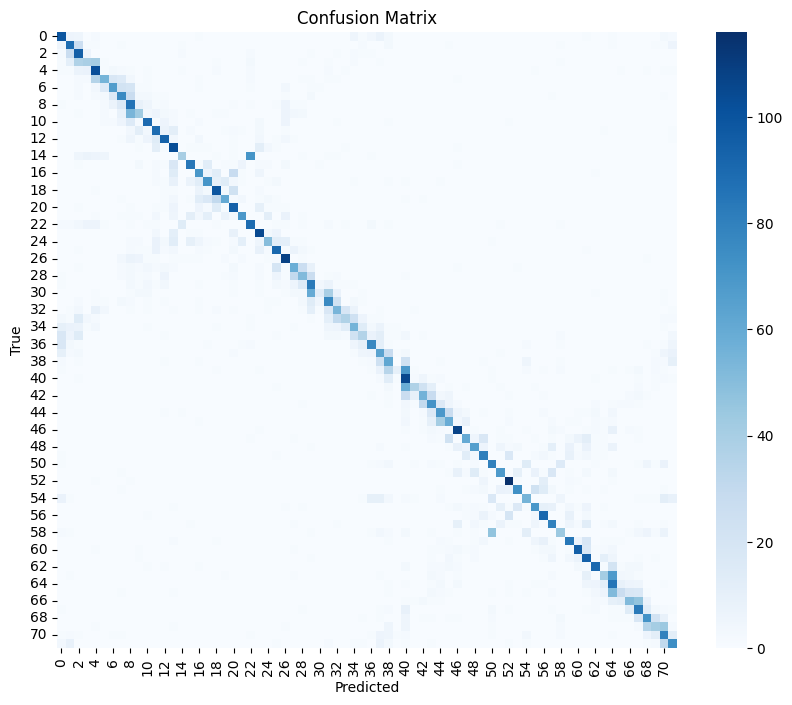

In [30]:
# 2️⃣ 加载模型权重
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model = SoundLocalizationModel(num_classes=72, input_channels_per_cue=32, conv_channels=64, kernel_size=5,
                               stride=1, num_layers=2, embed_dim=64, num_heads=4, use_batchnorm=True).to(device)
model_path = r"C:\Users\TIANY1\OneDrive - Trinity College Dublin\Documents\SoundSourceLocalization\checkpoints\model2\epoch_20.pth"

checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# 3️⃣ 准备测试集
val_path = r"C:\Users\TIANY1\OneDrive - Trinity College Dublin\Documents\SoundSourceLocalization\features"
val_dataset = BinauralCueDataset(val_path, audio_ids=range(561, 701))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# 4️⃣ 推理并收集预测
all_preds, all_labels = [], []

with torch.no_grad():
    for X, y in val_loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = np.mean(all_preds == all_labels)
print(f"🎯 Top-1 Accuracy: {accuracy * 100:.2f}%")

def mean_class_accuracy(y_true, y_pred, num_classes=72):
    class_accs = []
    for cls in range(num_classes):
        cls_mask = (y_true == cls)
        if cls_mask.sum() == 0: continue
        acc = (y_pred[cls_mask] == y_true[cls_mask]).sum() / cls_mask.sum()
        class_accs.append(acc)
    return np.mean(class_accs)

mean_acc = mean_class_accuracy(all_labels, all_preds)
print(f"📊 Mean Accuracy per Class: {mean_acc * 100:.2f}%")

from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, digits=3))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

